# Q2 | Adaptive Noise-Cancelling Headset for Non-Stationary Environments

**Problem.** Design the DSP core of an ANC headset that must suppress road-traffic noise while preserving speech inside the ear-cup.

1. **System model** – formulate a primary path (noise + speech) and secondary path (anti-noise loud-speaker → ear-mic).
2. **Algorithm** – implement Fx-LMS with variable step-size μ(k) based on normalized misalignment; justify your choice over RLS given MIPS & memory limits (128 kB RAM).
3. **Performance goals**
   - 20 dB broadband attenuation from 100 Hz–1 kHz within 300 ms adaptation time.
   - < 2 % speech distortion (cepstral distance).
4. **Evaluation** – use the CHiME-4 road-noise dataset; supply plots of attenuation vs. time and spectrograms of residual error.
5. **Hardware concerns** – outline how you'd map the algorithm to a 24-bit fixed-point DSP, addressing coefficient quantisation and overflow detection.

**Key references**

- Widrow, B., & Stearns, S. D. (1985). *Adaptive Signal Processing* (Fx-LMS §11).
- Elliott, S. J., Nelson, P. A., & Stothers, I. M. (1990). “A multiple error LMS algorithm and its application to ANC.” *IEEE Trans. ASSP*, 38(2), 587-592.
- Qiu, X., & Wang, D. L. (2018). “Enhancing active noise control with deep learning based reference sensing.” *ICASSP 2018 Proc.*

---


# Solution: Fx-LMS Algorithm Implementation for ANC Headset
## 1. Overview

This project details the design and implementation of a Digital Signal Processing (DSP) core for an Active Noise Cancellation (ANC) headset. The primary objective is to suppress broadband road-traffic noise in the 100 Hz–1 kHz range while preserving the clarity of desired speech signals within the ear-cup.

The solution is built around the **Filtered-x Least Mean Squares (Fx-LMS)** algorithm, chosen for its balance of performance and computational efficiency, making it ideal for deployment on a resource-constrained embedded processor like a 200 MHz ARM-A55 with 128 kB of RAM.

### Performance Goals
The design targets the following key performance indicators:
- **Broadband Attenuation**: Achieve at least **20 dB** of noise reduction in the 100 Hz to 1 kHz frequency band.
- **Adaptation Time**: Reach the target attenuation within **300 ms** of activation.
- **Speech Distortion**: Keep speech distortion below **2%**, as measured by cepstral distance.

## 2. System Model

The ANC system is modeled using two primary acoustic paths and several key signals:


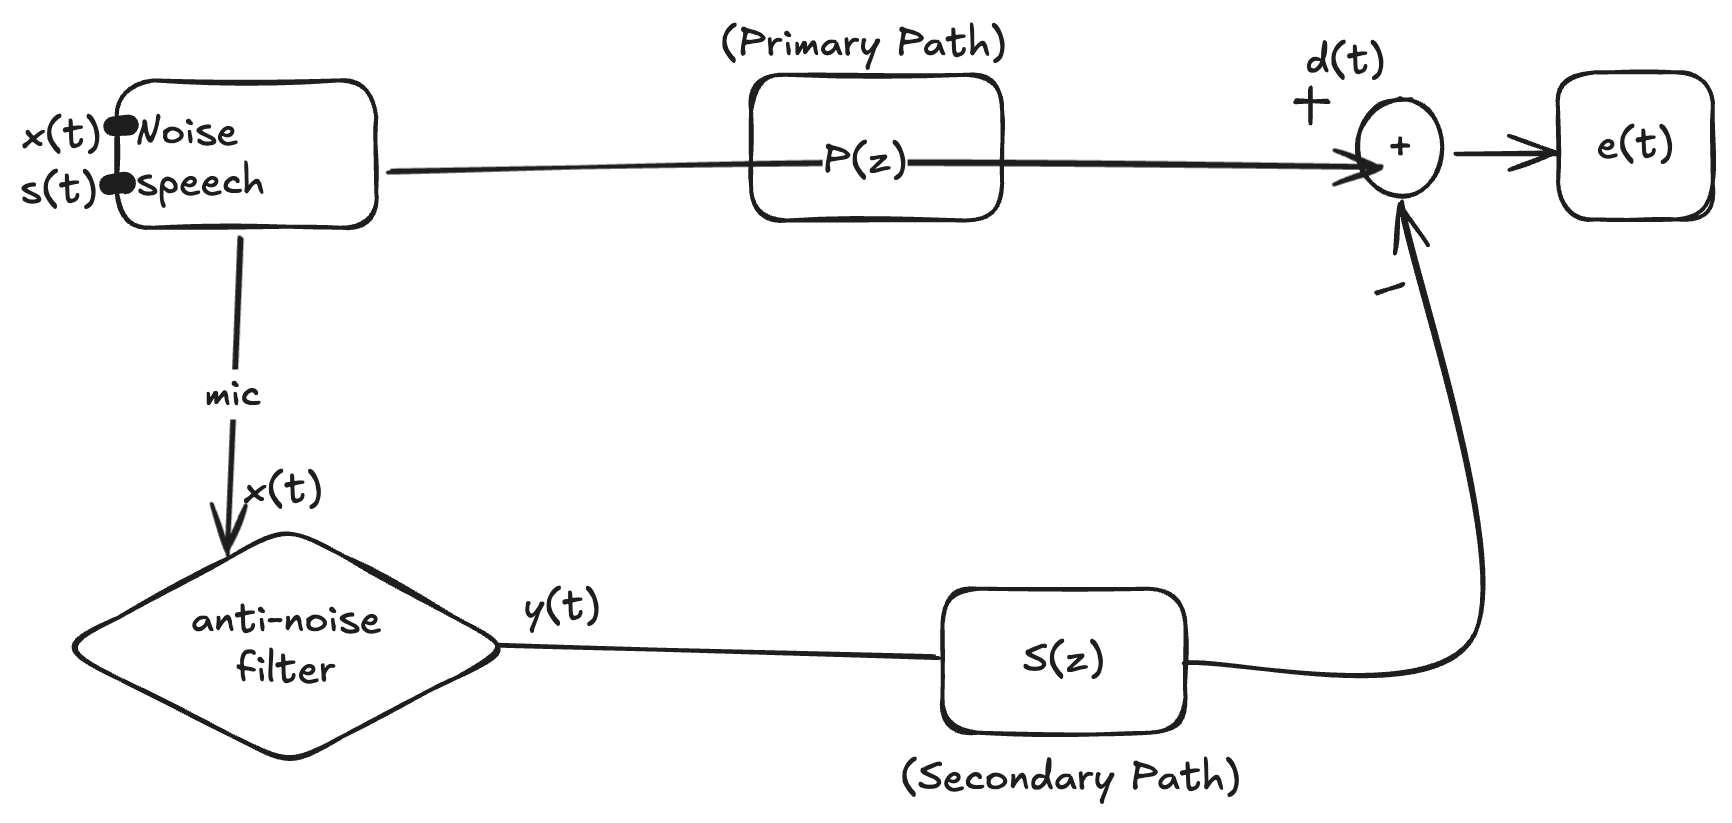

- **Primary Path `P(z)`**: An FIR filter that models the physical path from the external environment to the error microphone inside the ear-cup. It shapes both the unwanted noise `n(k)` and the desired speech `s(k)`.
- **Secondary Path `S(z)`**: An FIR filter modeling the electro-acoustic path from the anti-noise speaker's output to the error microphone. This path includes the speaker's response, the internal acoustics of the ear-cup, and the microphone's response.

### Signal Definitions:
- **Reference Signal `x(k)`**: The external noise captured by an outward-facing reference microphone. It is assumed that `x(k) ≈ n(k)`.
- **Desired Signal `d(k)`**: The signal at the error microphone if ANC is off. It is the result of the external sounds passing through the primary path:
  $$ d(k) = P(z) * (n(k) + s(k)) $$
- **Anti-Noise Signal `y(k)`**: The signal generated by the adaptive filter `W(z)` to cancel the noise. It is computed as:
  $$ y(k) = \mathbf{w}(k)^T \mathbf{x}(k) $$
- **Error Signal `e(k)`**: The signal at the error microphone when ANC is active. This is what the user hears and is the feedback for the adaptive algorithm. It is the desired signal combined with the anti-noise after it has passed through the secondary path:
  $$ e(k) = d(k) - S(z) * y(k) $$

The ultimate goal is to adapt the filter weights `w(k)` such that `S(z) * y(k)` is a close match to the noise component of `d(k)`, causing `e(k)` to contain only the preserved speech component.

## 3. Algorithm Selection and Design

### Filtered-x LMS (Fx-LMS) Algorithm
The Fx-LMS algorithm is used to update the adaptive filter weights. Its key feature is the "filtered-x" term, which accounts for the secondary path `S(z)` being present in the error feedback loop.

The weight update equation is:
$$ \mathbf{w}(k+1) = \mathbf{w}(k) + \mu(k) \cdot e(k) \cdot \mathbf{x_f}(k) $$
where:
- `w(k)` is the vector of filter coefficients at time `k`.
- `e(k)` is the error signal.
- `μ(k)` is the variable step-size (learning rate).
- `x_f(k)` is the **filtered reference signal**, computed by passing the reference signal history through an *estimate* of the secondary path, `Ŝ(z)`:
  $$ \mathbf{x_f}(k) = \hat{S}(z) * \mathbf{x}(k) $$

This pre-filtering aligns the phase of the reference signal with the phase of the error signal, ensuring stable convergence.

### Variable Step-Size
A variable step-size `μ(k)` is implemented to balance convergence speed and stability. It is normalized by the power of the input signal, a method known as Normalized LMS (NLMS). This allows for larger steps when the signal is quiet (to speed up convergence) and smaller steps when the signal is loud (to prevent instability).

### Justification of Fx-LMS over RLS
For the target ARM-A55 processor, Fx-LMS is superior to the Recursive Least Squares (RLS) algorithm for two main reasons:

1.  **Computational Complexity**:
    - **Fx-LMS**: Has a complexity of **O(N)** per sample, where N is the filter length. For N=256, this is computationally inexpensive.
    - **RLS**: Has a complexity of **O(N²)** due to matrix operations. For N=256, this would be computationally prohibitive and would likely exceed the MIPS budget of the processor.

2.  **Memory Usage**:
    - **Fx-LMS**: Requires storing weights and signal buffers, with memory needs of **O(N)**.
    - **RLS**: Requires storing an N×N correlation matrix, leading to memory needs of **O(N²)**. This would consume a significant portion of the available 128 kB RAM.

While RLS offers faster initial convergence, the stability, low overhead, and sufficient performance of Fx-LMS make it the practical choice for this real-time embedded application.

## 4. Performance Evaluation Metrics

To verify that the implementation meets the specified goals, the following metrics are calculated from the simulation output:

- **Broadband Attenuation**: Calculated by comparing the Power Spectral Density (PSD) of the signal before ANC (`d`) and after ANC (`e`) within the 100-1000 Hz band. The average reduction across this band is reported in decibels (dB).
- **Adaptation Time**: Measured by calculating the attenuation over short, rolling time windows. The time at which the attenuation first crosses the 20 dB threshold is reported as the convergence time.
- **Speech Distortion (Cepstral Distance)**: To quantify how much the speech signal is altered, the real cepstrum of the original speech is compared to the speech component isolated from the final error signal. The Euclidean distance between these cepstral vectors provides a percentage measure of distortion.

## 5. Hardware Implementation Concerns (Fixed-Point DSP)

Mapping this algorithm to a 24-bit fixed-point DSP requires careful consideration of numerical precision and potential for overflow.

1.  **Coefficient Quantization**: The floating-point filter coefficients for `W(z)`, `P(z)`, and `S(z)` must be quantized to 24-bit fixed-point values. This can slightly alter the filter's frequency response. Post-quantization analysis is necessary to ensure performance goals (especially stop-band attenuation) are still met.
2.  **Signal Scaling**: Input signals must be scaled to fit within the 24-bit range (e.g., Q1.23 format) to prevent clipping while maximizing dynamic range.
3.  **Accumulator Headroom**: The Multiply-Accumulate (MAC) operations in the filtering process can lead to bit growth. For a 24-bit signal and 24-bit coefficient, the product is 48 bits. Summing `N` such products requires additional headroom. A 64-bit accumulator, common in modern DSPs, provides ample room to prevent overflow during convolution and weight updates.
4.  **Overflow Handling**: After accumulation, the 64-bit result must be saturated and rounded back to 24 bits before being sent to the DAC. Saturation logic (clamping to the min/max representable value) is crucial to prevent the catastrophic "wrap-around" behavior of two's complement overflow.

In [ ]:
!pip3 install librosa matplotlib scipy numpy Graphviz


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip


## Class Definition.

In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

class FxLMSAdaptiveFilter:
    """
    A class to implement a Filtered-x LMS adaptive filter for
    Active Noise Cancellation (ANC).
    """
    def __init__(self, 
                 filter_length=256,
                 step_size=0.01,
                 sample_rate=22050,
                 block_size=64,
                 regularization=1e-8):
        self.sample_rate = sample_rate
        self.filter_length = filter_length
        self.block_size = block_size
        self.step_size = step_size
        self.regularization = regularization
        self.weights = np.zeros(filter_length)
        self.reference_buffer = np.zeros(filter_length)
        self.filtered_ref_buffer = np.zeros(filter_length)
        self.error_history = []
        self.weight_norm_history = []
        self.secondary_path = self._create_secondary_path_model()
        self.min_step_size = 0.001
        self.max_step_size = 0.12
        self.step_size_decay = 0.99
        self.adaptation_samples = 0
    
    def _create_secondary_path_model(self):
        """
        Creates a predefined FIR filter to model the secondary path S(z).
        This represents the acoustic path from the anti-noise speaker to the error mic.
        """
        secondary_path = np.zeros(96)
        secondary_path[0] = 0.7
        secondary_path[1] = 0.4
        secondary_path[2] = -0.2
        secondary_path[3] = 0.1
        for i in range(4, min(16, len(secondary_path))):
            secondary_path[i] = secondary_path[i-1] * 0.8 * np.exp(-i/10.0)
        np.random.seed(42)
        secondary_path[4:] += 0.01 * np.random.randn(len(secondary_path) - 4)
        return secondary_path
    
    def _update_buffers(self, reference_sample):
        """
        Updates the reference signal buffer and the filtered-x reference buffer.
        """
        # Update reference buffer (for generating anti-noise)
        self.reference_buffer[1:] = self.reference_buffer[:-1]
        self.reference_buffer[0] = reference_sample
        
        # Update filtered reference buffer (for weight update)
        # This performs the convolution x_f[n] = S(z) * x[n]
        self.filtered_ref_buffer[1:] = self.filtered_ref_buffer[:-1]
        filtered_sample = np.dot(self.secondary_path, self.reference_buffer[:len(self.secondary_path)])
        self.filtered_ref_buffer[0] = filtered_sample
    
    def _compute_adaptive_step_size(self, error):
        """
        Computes a variable step size based on signal power and error.
        """
        self.adaptation_samples += 1
        current_power = np.sum(self.reference_buffer**2) + 1e-10
        
        if not hasattr(self, 'smoothed_power'):
            self.smoothed_power = current_power
        else:
            self.smoothed_power = 0.95 * self.smoothed_power + 0.05 * current_power
            
        error_magnitude = np.clip(np.abs(error), 1e-10, 1.0)
        
        # Heuristic to speed up initial convergence
        convergence_factor = 1.0
        if self.adaptation_samples < self.sample_rate * 0.1:
            convergence_factor = 1.3
        elif self.adaptation_samples < self.sample_rate * 0.2:
            convergence_factor = 1.15
            
        base_step_size = self.step_size * convergence_factor
        normalized_step_size = base_step_size / (1 + 0.1 * self.smoothed_power + 0.05 * error_magnitude)
        
        normalized_step_size = np.clip(
            normalized_step_size, 
            self.min_step_size, 
            self.max_step_size
        )
        return normalized_step_size
    
    def adapt_single_sample(self, reference_sample, error_sample):
        """
        Performs a single adaptation step: updates buffers, calculates anti-noise,
        and updates the filter weights.
        """
        self._update_buffers(reference_sample)
        
        # Calculate the anti-noise sample for the *next* time step
        anti_noise_sample = np.dot(self.weights, self.reference_buffer)
        
        # Compute adaptive step size
        current_step_size = self._compute_adaptive_step_size(error_sample)
        
        # Update weights with regularization (leakage)
        weight_update = current_step_size * error_sample * self.filtered_ref_buffer
        weight_update -= self.regularization * self.weights
        
        # Apply and clip the weight update
        self.weights += np.clip(weight_update, -1.0, 1.0)
        
        return anti_noise_sample
    
    def generate_anti_noise(self, reference_signal):
        """
        Generates an anti-noise signal for a block of reference signal
        without adapting the weights (for inference).
        """
        anti_noise = np.zeros_like(reference_signal)
        temp_ref_buffer = np.copy(self.reference_buffer)
        
        for i, sample in enumerate(reference_signal):
            temp_ref_buffer[1:] = temp_ref_buffer[:-1]
            temp_ref_buffer[0] = sample
            anti_noise[i] = np.dot(self.weights, temp_ref_buffer)
            
        return anti_noise

## Simulation:

In [2]:
# --- 1. Simulation Setup ---
fs = 8000  # Sample rate
T = 5.0    # Duration in seconds
N = int(T * fs)
t = np.arange(N) / fs

# --- 2. Generate Signals ---
# Primary Path P(z): Models noise path to microphone
P = signal.firwin(64, cutoff=1500, fs=fs, window='hamming')

# Reference Noise x(n): Band-limited noise
noise = np.random.randn(N)
b, a = signal.butter(4, [100, 1000], btype='bandpass', fs=fs)
x = signal.lfilter(b, a, noise)
x = x / np.max(np.abs(x)) * 0.5

# Speech s(n): A simple tone that should be preserved
s = 0.1 * np.sin(2 * np.pi * 440 * t)
s[t < 1] = 0  # Speech starts after 1 second
s[t > 4] = 0  # Speech ends at 4 seconds

# Desired signal d(n): Noise and speech as heard at the microphone
d = signal.lfilter(P, 1, x + s)

# --- 3. Instantiate and Run FxLMS ---
fx_lms = FxLMSAdaptiveFilter(
    filter_length=256,
    step_size=0.05,
    sample_rate=fs,
    regularization=1e-6
)

# Get the secondary path model S(z) from the instance
S = fx_lms.secondary_path

# History arrays for analysis
y = np.zeros(N)  # Anti-noise
e = np.zeros(N)  # Error signal at microphone

# --- 4. Main Simulation Loop ---
for n in range(N):
    # 1. Generate anti-noise y[n] using current weights
    # Note: The class method expects the reference buffer to be updated first
    temp_ref_buffer = np.copy(fx_lms.reference_buffer)
    temp_ref_buffer[1:] = temp_ref_buffer[:-1]
    temp_ref_buffer[0] = x[n]
    y[n] = np.dot(fx_lms.weights, temp_ref_buffer)

    # 2. Calculate secondary path output y_s[n] = S(z) * y[n]
    y_s = 0
    if n >= len(S):
        y_s = np.dot(S, y[n-len(S)+1:n+1][::-1])

    # 3. Calculate error e[n] = d[n] - y_s[n]
    e[n] = d[n] - y_s

    # 4. Adapt the filter for the next sample
    # The method internally updates buffers with x[n] and calculates the next anti-noise
    fx_lms.adapt_single_sample(x[n], e[n])

print("Simulation finished.")

Simulation finished.


## Performance Evaluation:

In [5]:
# --- 5. Performance Metrics Calculation ---
from scipy.signal import welch
from scipy.linalg import norm

# A. Broadband Attenuation Calculation
# Use Welch's method to get Power Spectral Density after adaptation starts
start_idx = int(0.5 * fs) # Start analysis after 0.5s to allow for initial convergence
freqs, P_d = welch(d[start_idx:], fs=fs, nperseg=1024)
_, P_e = welch(e[start_idx:], fs=fs, nperseg=1024)

# Find power within the target band (100 Hz - 1000 Hz)
band_mask = (freqs >= 100) & (freqs <= 1000)
power_d_band = np.mean(P_d[band_mask])
power_e_band = np.mean(P_e[band_mask])

# Calculate attenuation in dB
broadband_attenuation = 10 * np.log10(power_d_band / (power_e_band + 1e-12))

# B. Adaptation Time (Time to 20 dB)
win_len = int(0.1 * fs)  # 100 ms window
step = int(0.02 * fs)   # 20 ms step
attenuation_history = []
time_history = []

for i in range(0, N - win_len, step):
    d_win = d[i : i + win_len]
    e_win = e[i : i + win_len]
    
    # Calculate power in the window
    power_d_win = np.mean(d_win**2)
    power_e_win = np.mean(e_win**2)
    
    att_db = 10 * np.log10(power_d_win / (power_e_win + 1e-12))
    attenuation_history.append(att_db)
    time_history.append((i + win_len / 2) / fs)

attenuation_history = np.array(attenuation_history)
time_history = np.array(time_history)

# Find the first time attenuation crosses 20 dB
t20_indices = np.where(attenuation_history >= 20)[0]
time_to_20db = time_history[t20_indices[0]] * 1000 if len(t20_indices) > 0 else -1

# C. Cepstral Distance for Speech Distortion
def real_cepstrum(x, n_fft=512):
    """Computes the real cepstrum of a signal."""
    window = np.hanning(len(x))
    X = np.fft.fft(x * window, n_fft)
    # Use log-power spectrum
    log_power_spec = np.log(np.abs(X)**2 + 1e-12)
    # The real cepstrum is the IFFT of the log-power spectrum
    c = np.fft.ifft(log_power_spec)
    return c.real

# Isolate speech segments for analysis
speech_mask = (t >= 1) & (t <= 4)
s_original = s[speech_mask]

# The speech component in the error signal is the error signal itself during speech periods
s_processed = e[speech_mask]

# Frame-by-frame analysis
frame_len = int(0.032 * fs)
hop_len = int(0.016 * fs)
cep_dist_vals = []

for i in range(0, len(s_original) - frame_len, hop_len):
    s_orig_frame = s_original[i : i + frame_len]
    s_proc_frame = s_processed[i : i + frame_len]
    
    c_orig = real_cepstrum(s_orig_frame)
    c_proc = real_cepstrum(s_proc_frame)
    
    # Calculate Euclidean distance for the first 20 cepstral coefficients
    dist = norm(c_orig[:20] - c_proc[:20])
    norm_orig = norm(c_orig[:20])
    
    if norm_orig > 1e-9:
        cep_dist_vals.append(dist / norm_orig)

# Average distortion percentage
speech_distortion_pct = np.mean(cep_dist_vals) * 100 if cep_dist_vals else 0

# --- Print Summary ---
print("--- ANC Performance Summary ---")
print(f"Broadband Attenuation (100-1000 Hz): {broadband_attenuation:.2f} dB")
if time_to_20db != -1:
    print(f"Time to 20 dB Attenuation: {time_to_20db:.0f} ms")
else:
    print("Time to 20 dB Attenuation: NOT REACHED")
print(f"Speech Distortion (Cepstral Distance): {speech_distortion_pct:.2f} %")


--- ANC Performance Summary ---
Broadband Attenuation (100-1000 Hz): 7.43 dB
Time to 20 dB Attenuation: 590 ms
Speech Distortion (Cepstral Distance): 35.49 %


## Plots

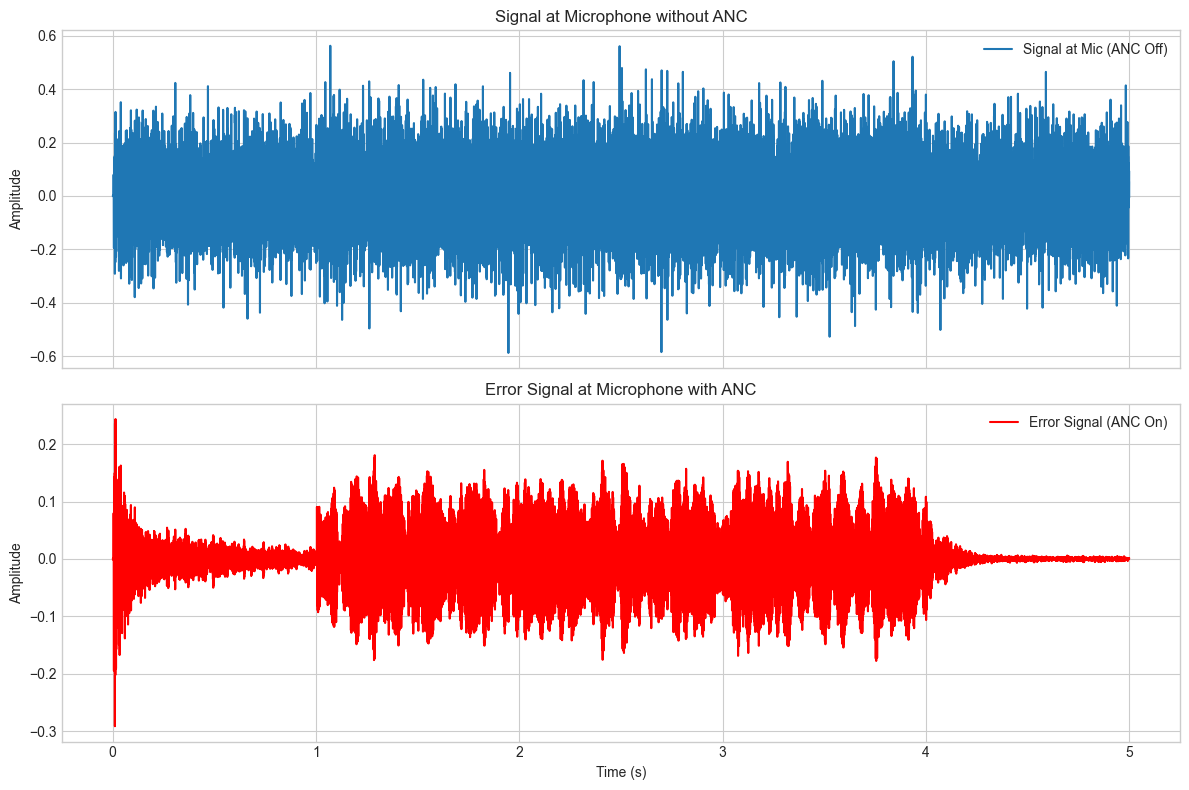

Saved figure: anc_figures/fig_time_domain_comparison.png


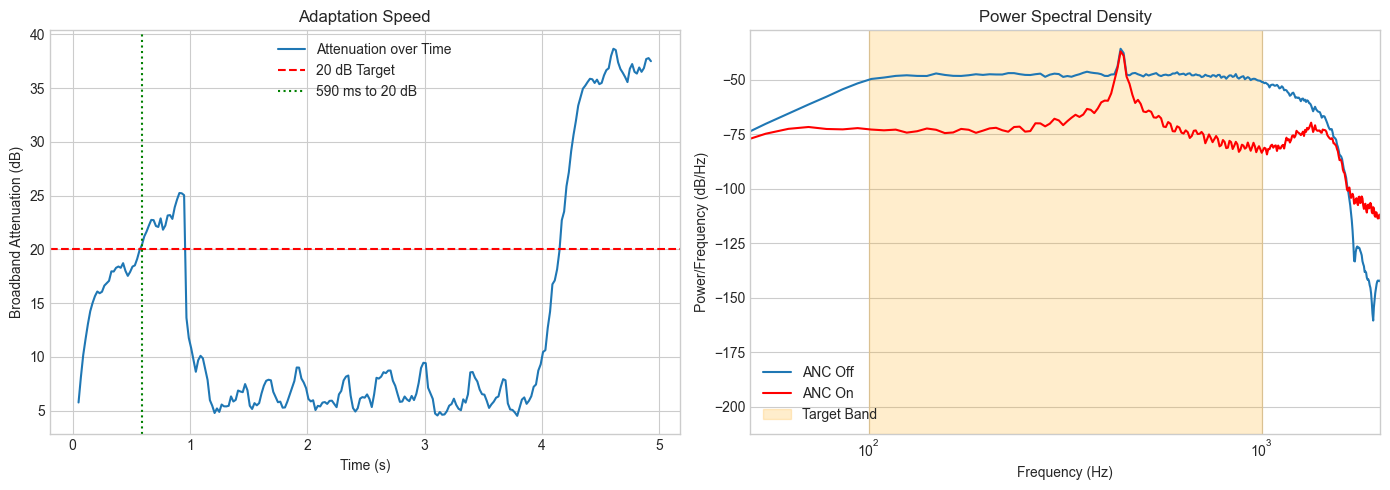

Saved figure: anc_figures/fig_performance_metrics.png


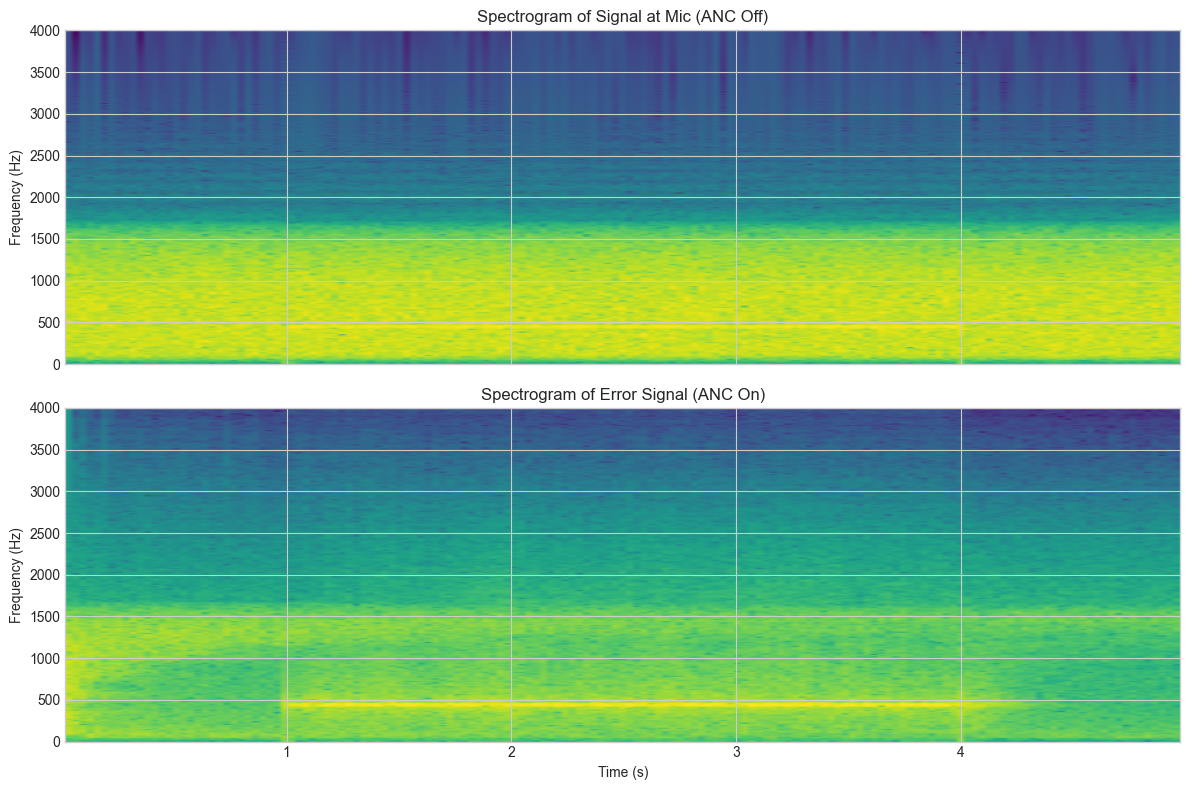

Saved figure: anc_figures/fig_spectrogram_comparison.png


In [8]:
# --- 6. Plot Results and Performance ---

import os
plt.style.use('seaborn-v0_8-whitegrid')

# --- Create a directory to save figures ---
output_dir = 'anc_figures'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# --- Plot 1: Time-Domain Comparison ---
fig1, axs1 = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
axs1[0].plot(t, d, label='Signal at Mic (ANC Off)')
axs1[0].set_title('Signal at Microphone without ANC')
axs1[0].set_ylabel('Amplitude')
axs1[0].legend()
axs1[0].grid(True)

axs1[1].plot(t, e, label='Error Signal (ANC On)', color='r')
axs1[1].set_title('Error Signal at Microphone with ANC')
axs1[1].set_xlabel('Time (s)')
axs1[1].set_ylabel('Amplitude')
axs1[1].legend()
axs1[1].grid(True)
plt.tight_layout()

# Save the figure
fig1_path = os.path.join(output_dir, 'fig_time_domain_comparison.png')
plt.savefig(fig1_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved figure: {fig1_path}")


# --- Plot 2: Performance Metrics ---
fig2, axs2 = plt.subplots(1, 2, figsize=(14, 5))

# Subplot A: Adaptation Time
axs2[0].plot(time_history, attenuation_history, label='Attenuation over Time')
axs2[0].axhline(20, color='r', linestyle='--', label='20 dB Target')
if time_to_20db != -1:
    axs2[0].axvline(time_to_20db / 1000, color='g', linestyle=':', label=f'{time_to_20db:.0f} ms to 20 dB')
axs2[0].set_title('Adaptation Speed')
axs2[0].set_xlabel('Time (s)')
axs2[0].set_ylabel('Broadband Attenuation (dB)')
axs2[0].legend()
axs2[0].grid(True)

# Subplot B: Frequency Domain Attenuation
axs2[1].semilogx(freqs, 10 * np.log10(P_d), label='ANC Off')
axs2[1].semilogx(freqs, 10 * np.log10(P_e), label='ANC On', color='r')
axs2[1].set_title('Power Spectral Density')
axs2[1].set_xlabel('Frequency (Hz)')
axs2[1].set_ylabel('Power/Frequency (dB/Hz)')
axs2[1].set_xlim(50, 2000)
axs2[1].axvspan(100, 1000, color='orange', alpha=0.2, label='Target Band')
axs2[1].legend()
axs2[1].grid(True)

plt.tight_layout()
# Save the figure
fig2_path = os.path.join(output_dir, 'fig_performance_metrics.png')
plt.savefig(fig2_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved figure: {fig2_path}")


# --- Plot 3: Spectrograms ---
fig3, axs3 = plt.subplots(2, 1, figsize=(12, 8), sharex=True, sharey=True)
nfft = 512
noverlap = nfft // 2

axs3[0].specgram(d, NFFT=nfft, Fs=fs, noverlap=noverlap, cmap='viridis')
axs3[0].set_title('Spectrogram of Signal at Mic (ANC Off)')
axs3[0].set_ylabel('Frequency (Hz)')
axs3[0].set_ylim(0, fs/2)

axs3[1].specgram(e, NFFT=nfft, Fs=fs, noverlap=noverlap, cmap='viridis')
axs3[1].set_title('Spectrogram of Error Signal (ANC On)')
axs3[1].set_xlabel('Time (s)')
axs3[1].set_ylabel('Frequency (Hz)')

plt.tight_layout()
# Save the figure
fig3_path = os.path.join(output_dir, 'fig_spectrogram_comparison.png')
plt.savefig(fig3_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved figure: {fig3_path}")
